Task 5: Movie Recommendation System Description

Description:

Dataset (Recommended): MovieLens 100K Dataset (Kaggle)
Build a system that recommends movies based on user similarity
Use a user-item matrix to compute similarity scores
Recommend top-rated unseen movies for a given user
Evaluate performance using precision at K

Tools & Libraries: Python Pandas Numpy Scikit-learn

Covered Topics: Recommendation systems | Similarity-based modeling

Bonus: Implement item-based collaborative filtering. Try matrix factorization (SVD)

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_score

In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive (8).zip to archive (8).zip


In [12]:
df = pd.read_csv('/content/ml-100k/u.data', sep='\t', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'])

In [8]:
import os

print(os.listdir('/content/ml-100k'))

['u.data', 'u4.test', 'ua.test', 'u.occupation', 'u4.base', 'u2.base', 'u.info', 'ua.base', 'u2.test', 'u1.test', 'ub.test', 'ub.base', 'u.user', 'u.item', 'mku.sh', 'u3.test', 'u.genre', 'u3.base', 'README', 'u5.base', 'u1.base', 'allbut.pl', 'u5.test']


In [13]:
df

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


Overview

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   item_id    100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB


In [16]:
print("Shape:", df.shape)

Shape: (100000, 4)


In [17]:
print(df.dtypes)

user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object


In [19]:
df.isnull().sum()
duplicated = df.duplicated()
duplicated.sum()

np.int64(0)

In [20]:
df.describe()

,user_id,item_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [21]:
df.user_id.value_counts()

,count
user_id,
405,737
655,685
13,636
450,540
276,518
...,...
36,20
418,20
558,20


<Axes: xlabel='user_id', ylabel='Count'>

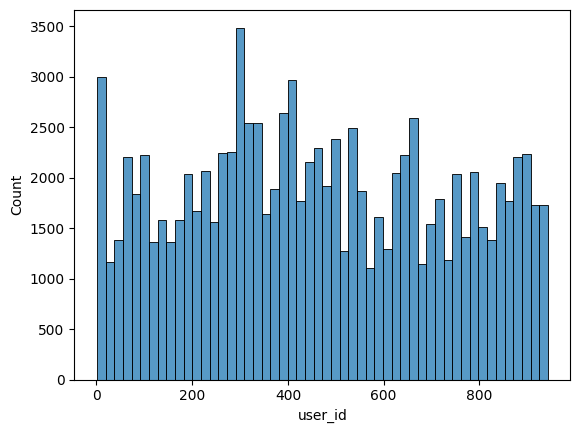

In [22]:
sns.histplot(df['user_id'])

In [23]:
df.item_id.value_counts()

,count
item_id,
50,583
258,509
100,508
181,507
294,485
...,...
1647,1
1618,1
1632,1


<Axes: xlabel='item_id', ylabel='Count'>

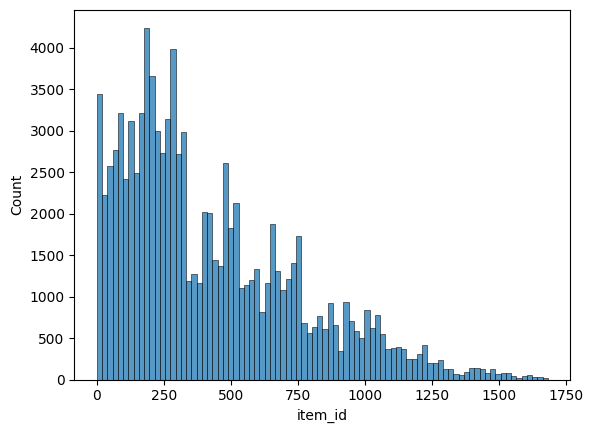

In [24]:
sns.histplot(df['item_id'])

In [25]:
df.rating.value_counts()

,count
rating,
4,34174
3,27145
5,21201
2,11370
1,6110


<Axes: xlabel='rating', ylabel='Count'>

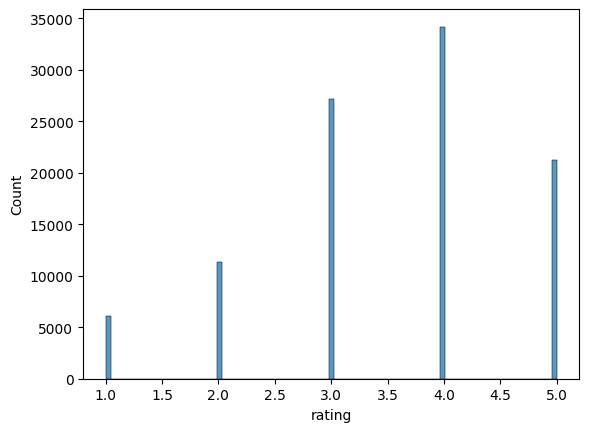

In [26]:
sns.histplot(df['rating'])

In [27]:
df.timestamp.value_counts()

,count
timestamp,
891033606,12
888552084,10
884114471,10
879217689,10
878962623,10
...,...
880525815,1
879437997,1
891035994,1


<Axes: xlabel='timestamp', ylabel='Count'>

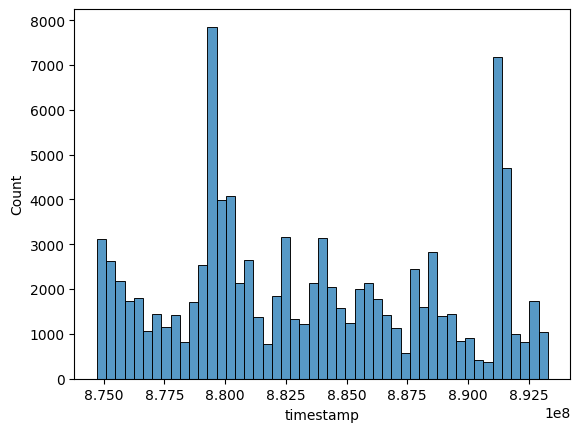

In [28]:
sns.histplot(df['timestamp'])

Build User-Item **Matrix**

In [33]:
user_item_matrix = df.pivot_table(index="user_id", columns="item_id", values="rating")
user_item_matrix.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Data Exploration and ***Visualizations***

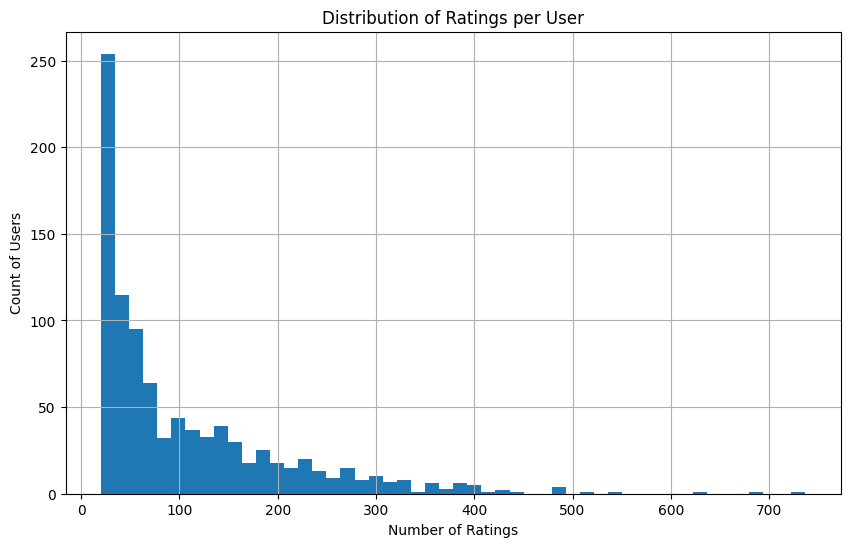

In [65]:
# Data Exploration: Distribution of Ratings per User
user_counts = df['user_id'].value_counts() # Calculate the number of ratings per user

plt.figure(figsize=(10,6))
plt.hist(user_counts, bins=50)
plt.title('Distribution of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.grid(True)

import os
if not os.path.exists('plots'):
    os.makedirs('plots')
plt.savefig('plots/ratings_per_user.png')
plt.show()

Compute User **Similarity**

In [36]:
user_similarity = cosine_similarity(user_item_matrix.fillna(0))
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
user_similarity_df.head()


user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.166931,0.047460,0.064358,0.378475,0.430239,0.440367,0.319072,0.078138,0.376544,...,0.369527,0.119482,0.274876,0.189705,0.197326,0.118095,0.314072,0.148617,0.179508,0.398175
2,0.166931,1.000000,0.110591,0.178121,0.072979,0.245843,0.107328,0.103344,0.161048,0.159862,...,0.156986,0.307942,0.358789,0.424046,0.319889,0.228583,0.226790,0.161485,0.172268,0.105798
3,0.047460,0.110591,1.000000,0.344151,0.021245,0.072415,0.066137,0.083060,0.061040,0.065151,...,0.031875,0.042753,0.163829,0.069038,0.124245,0.026271,0.161890,0.101243,0.133416,0.026556
4,0.064358,0.178121,0.344151,1.000000,0.031804,0.068044,0.091230,0.188060,0.101284,0.060859,...,0.052107,0.036784,0.133115,0.193471,0.146058,0.030138,0.196858,0.152041,0.170086,0.058752
5,0.378475,0.072979,0.021245,0.031804,1.000000,0.237286,0.373600,0.248930,0.056847,0.201427,...,0.338794,0.080580,0.094924,0.079779,0.148607,0.071459,0.239955,0.139595,0.152497,0.313941


User Similarity **Heatmap**

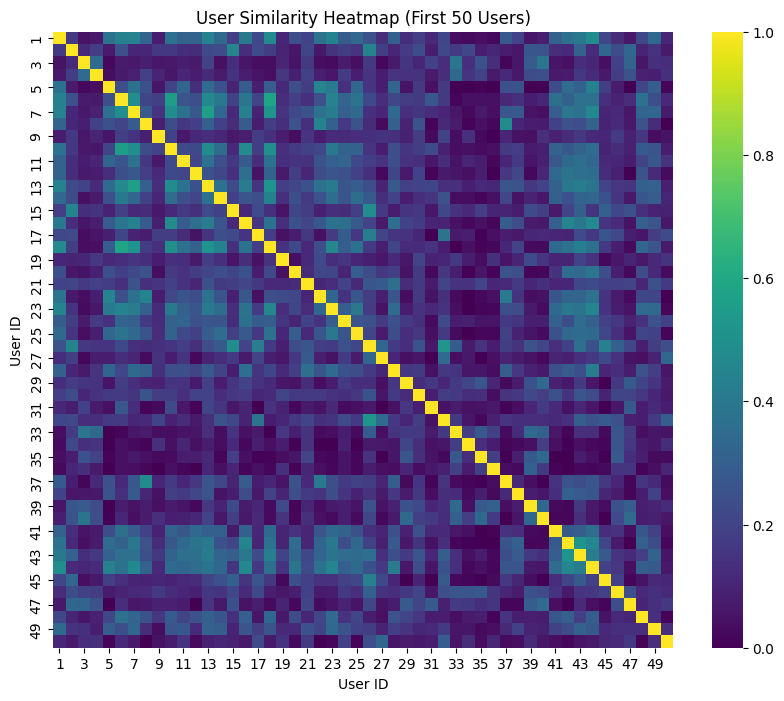

In [67]:
# Compute user similarity matrix (subset for visualization)
plt.figure(figsize=(10,8))
sns.heatmap(user_similarity_df.iloc[:50, :50], cmap='viridis', annot=False) # Use user_similarity_df
plt.title('User Similarity Heatmap (First 50 Users)')
plt.xlabel('User ID')
plt.ylabel('User ID')
plt.savefig('plots/user_similarity_heatmap.png')
plt.show()

Item Similarity Heatmap

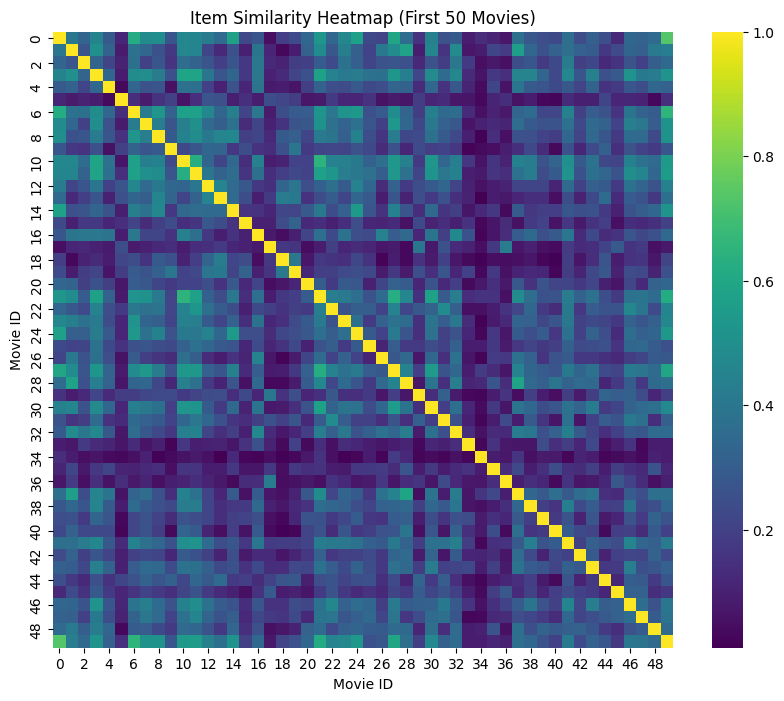

In [69]:
# Transpose for item-based similarity (subset for visualization)
item_item = df.pivot(index='item_id', columns='user_id', values='rating').fillna(0)
item_similarity = cosine_similarity(item_item)
plt.figure(figsize=(10,8))
sns.heatmap(item_similarity[:50, :50], cmap='viridis', annot=False)
plt.title('Item Similarity Heatmap (First 50 Movies)')
plt.xlabel('Movie ID')from scipy.sparse.linalg import svds

plt.ylabel('Movie ID')
plt.savefig('plots/item_similarity_heatmap.png')
plt.show()

**Recommend Movies**
User-based Collaborative Filtering

In [47]:
def recommend_movies(user_id, n=5):
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).index[1:]
    recommendations = pd.Series(dtype=float)

    for u in similar_users:
        user_ratings = user_item_matrix.loc[u]
        user_ratings = user_ratings[user_ratings.notna()]
        recommendations = pd.concat([recommendations, user_ratings])

        if len(recommendations) > 50:
            break

    recommendations = recommendations.groupby(recommendations.index).mean()
    user_seen = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id].notna()].index
    recommendations = recommendations.drop(user_seen, errors="ignore")

    return recommendations.sort_values(ascending=False).head(n)


In [48]:
recommend_movies(user_id=1, n=10)


,0
421,5.0
425,5.0
919,5.0
483,5.0
512,5.0
1009,5.0
511,5.0
428,4.0
286,4.0
276,4.0


Evaluation: Precision@**K**

In [49]:
def precision_at_k(user_id, k=5):
    recs = recommend_movies(user_id, n=k)
    actual = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id].notna()].index
    hits = [movie for movie in recs.index if movie in actual]
    return len(hits) / k

precision_scores = [precision_at_k(u, k=5) for u in user_item_matrix.index]
np.mean(precision_scores)


np.float64(0.0)

**Bonus**

Bonus: Item-Based CF

In [51]:
item_similarity = cosine_similarity(user_item_matrix.T.fillna(0))
item_similarity_df = pd.DataFrame(
    item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns
)

def recommend_movies_item_based(user_id, top_n=5):
    """
    Recommend movies using item-based collaborative filtering
    """
    user_ratings = user_item_matrix.loc[user_id]
    scores = np.dot(user_ratings, item_similarity)
    scores = pd.Series(scores, index=user_item_matrix.columns)
    # Exclude already watched movies
    watched = user_ratings[user_ratings > 0].index
    scores = scores.drop(watched, errors="ignore")

    top_movies = scores.sort_values(ascending=False).head(top_n).index
    # Note: The 'movies' DataFrame is not defined. To get movie titles, you would need
    # to load the movie information dataset and merge it with the recommendations.
    # For now, I'll return the item_ids.
    return top_movies # Return item_ids directly

print("\nItem-Based Recommendations for User 10:")
print(recommend_movies_item_based(10, top_n=5))


Item-Based Recommendations for User 10:
Index([2, 3, 5, 6, 8], dtype='int64', name='item_id')


In [53]:
item_similarity = cosine_similarity(user_item_matrix.fillna(0).T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

def recommend_item_based(item_id, n=5):
    """
    Recommend similar items based on item similarity.
    """
    if item_id not in item_similarity_df.index:
        return f"Item ID {item_id} not found in the similarity matrix."

    similar_items = item_similarity_df[item_id].sort_values(ascending=False).index[1:n+1]
    return similar_items

# Example usage with an item_id (e.g., item_id 1 for 'Toy Story (1995)' based on u.item file)
# Note: You would need to consult the u.item file to find the correct item_id for a movie title.
print(recommend_item_based(1, n=5))

Index([50, 181, 121, 117, 405], dtype='int64', name='item_id')


Bonus: Matrix Factorization (SVD)

In [70]:
from scipy.sparse.linalg import svds


In [71]:
R = user_item_matrix.fillna(0).values
user_ratings_mean = np.mean(R, axis=1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)


In [72]:
U, sigma, Vt = svds(R_demeaned, k=50)
sigma = np.diag(sigma)


In [73]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
preds_df = pd.DataFrame(all_user_predicted_ratings, columns=user_item_matrix.columns, index=user_item_matrix.index)
preds_df.head()


item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,6.488436,2.959503,1.634987,3.024467,1.656526,1.659506,3.630469,0.240669,1.791518,3.347816,...,0.011976,-0.092017,-0.074553,-0.060985,0.009427,-0.035641,-0.039227,-0.037434,-0.025552,0.023513
2,2.347262,0.129689,-0.098917,0.328828,0.159517,0.481361,0.213002,0.097908,1.892100,0.671000,...,0.003943,-0.026939,-0.035460,-0.029883,-0.027153,-0.015244,-0.008277,-0.011760,0.011639,-0.046924
3,0.291905,-0.263830,-0.151454,-0.179289,0.013462,-0.088309,-0.057624,0.568764,-0.018506,0.280742,...,-0.028964,-0.031622,0.045513,0.026089,-0.021705,0.002282,0.032363,0.017322,-0.006644,-0.009480
4,0.366410,-0.443535,0.041151,-0.007616,0.055373,-0.080352,0.299015,-0.010882,-0.160888,-0.118834,...,0.020069,0.015981,-0.000182,0.005593,0.026634,0.023562,0.036405,0.029984,0.015612,-0.008713
5,4.263488,1.937122,0.052529,1.049350,0.652765,0.002836,1.730461,0.870584,0.341027,0.569055,...,0.019973,-0.053521,-0.017242,-0.007137,-0.038987,0.010338,0.004869,0.007603,-0.020575,0.003330


In [74]:
def recommend_movies_svd(user_id, n=5):
    user_row = preds_df.loc[user_id].sort_values(ascending=False)
    user_seen = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id].notna()].index
    recs = user_row.drop(user_seen, errors="ignore").head(n)
    return recs

recommend_movies_svd(user_id=1, n=10)


,1
item_id,
423,3.509642
403,3.097894
732,2.971226
357,2.752628
385,2.605706
303,2.574760
470,2.475011
367,2.432600
582,2.409058


**Comprare**

In [75]:
user_id = 1
movie_title = "Toy Story (1995)"

print("User-based Recommendations:")
print(recommend_movies(user_id=user_id, n=5))

print("\nItem-based Recommendations for:", movie_title)
print(recommend_item_based(movie_title, n=5))

print("\nSVD-based Recommendations:")
print(recommend_movies_svd(user_id=user_id, n=5))


User-based Recommendations:
421    5.0
425    5.0
919    5.0
483    5.0
512    5.0
dtype: float64

Item-based Recommendations for: Toy Story (1995)
Item ID Toy Story (1995) not found in the similarity matrix.

SVD-based Recommendations:
item_id
423    3.509642
403    3.097894
732    2.971226
357    2.752628
385    2.605706
Name: 1, dtype: float64


In [76]:
user_recs = recommend_movies(user_id=1, n=5)
svd_recs = recommend_movies_svd(user_id=1, n=5)

comparison_df = pd.DataFrame({
    "User-based": user_recs.index.values,
    "SVD-based": svd_recs.index.values
})
comparison_df


,User-based,SVD-based
0,421,423
1,425,403
2,919,732
3,483,357
4,512,385


Bar chart

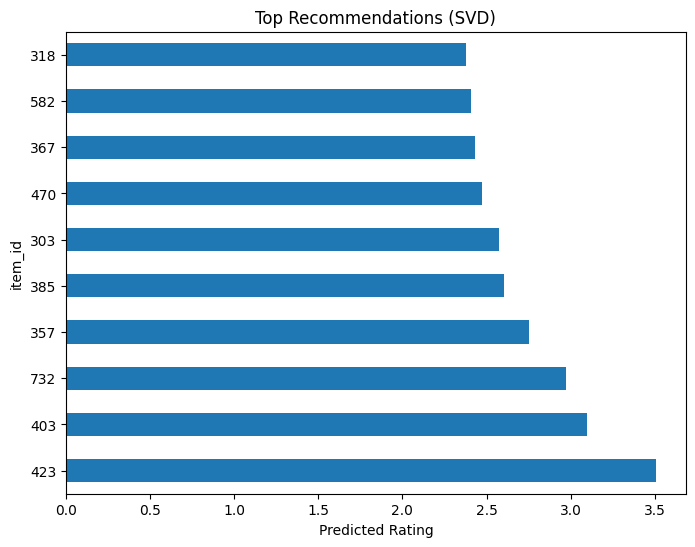

In [77]:
svd_recs_full = recommend_movies_svd(user_id=1, n=10)
svd_recs_full.plot(kind="barh", figsize=(8,6))
plt.xlabel("Predicted Rating")
plt.title("Top Recommendations (SVD)")
plt.show()


Ratings Distribution

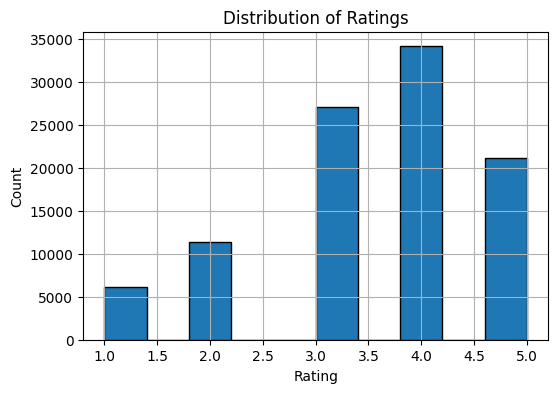

In [78]:
plt.figure(figsize=(6,4))
df['rating'].hist(bins=10, edgecolor="black")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of Ratings")
plt.show()


Top Rated by Count

In [80]:
# Load movie information
movie_cols = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_df = pd.read_csv('/content/ml-100k/u.item', sep='|', header=None, names=movie_cols, encoding='latin-1')

# Select only item_id and title
movies_df = movies_df[['item_id', 'title']]

display(movies_df.head())

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [81]:
# Merge df with movies_df to get movie titles
df_merged = pd.merge(df, movies_df, on='item_id')
display(df_merged.head())

,user_id,item_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


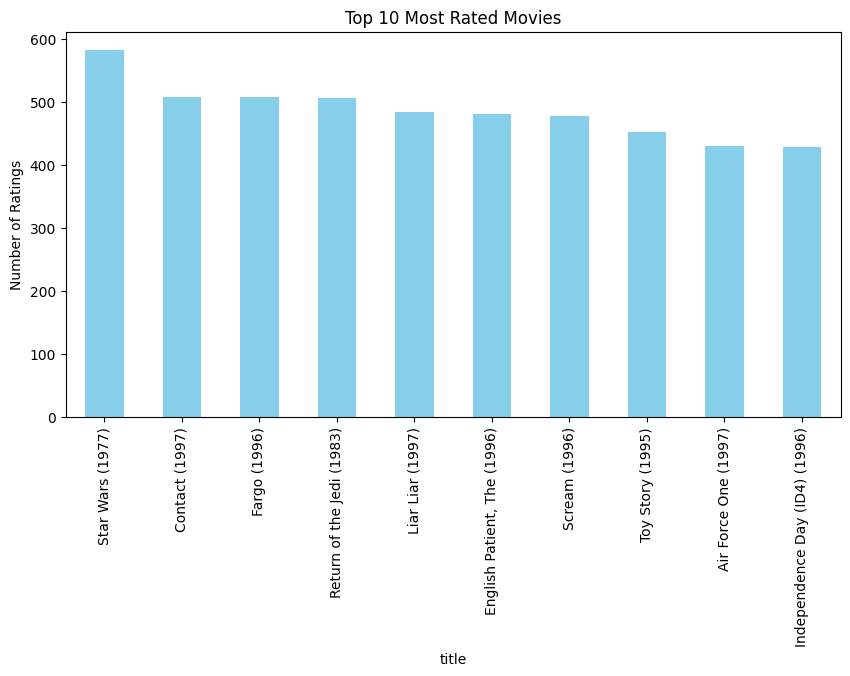

In [82]:
top_movies = df_merged.groupby("title")["rating"].count().sort_values(ascending=False).head(10)
top_movies.plot(kind="bar", figsize=(10,5), color="skyblue")
plt.title("Top 10 Most Rated Movies")
plt.ylabel("Number of Ratings")
plt.show()

Top Movies by Average Rating, min 100 ratings

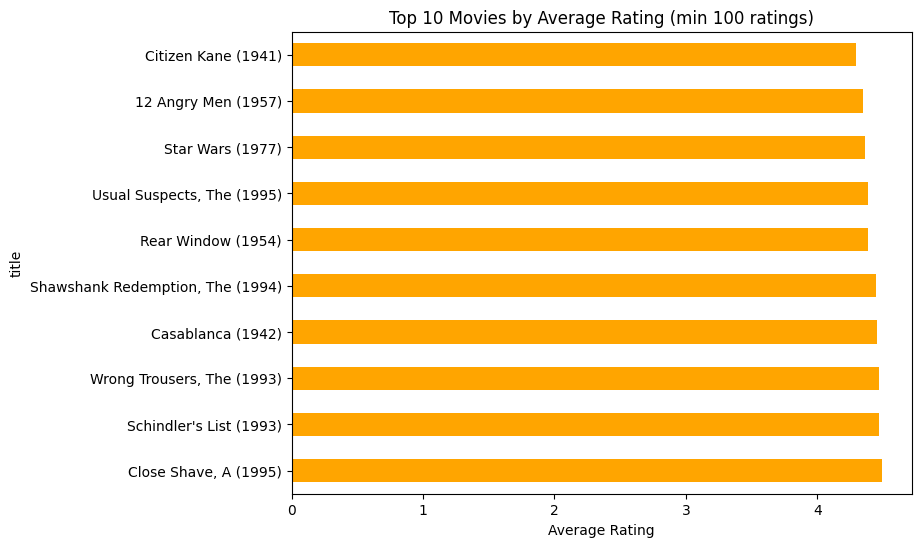

In [84]:
avg_ratings = df_merged.groupby("title")["rating"].mean()
count_ratings = df_merged.groupby("title")["rating"].count()
avg_df = pd.DataFrame({"avg_rating": avg_ratings, "count": count_ratings})
top_avg_movies = avg_df[avg_df["count"]>=100].sort_values("avg_rating", ascending=False).head(10)

top_avg_movies["avg_rating"].plot(kind="barh", figsize=(8,6), color="orange")
plt.title("Top 10 Movies by Average Rating (min 100 ratings)")
plt.xlabel("Average Rating")
plt.show()

Item-based Similarity Heatmap

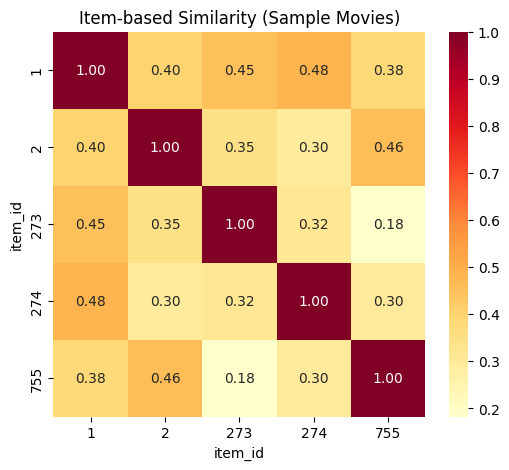

In [86]:
sample_movies = ["Toy Story (1995)", "Jumanji (1995)", "GoldenEye (1995)", "Heat (1995)", "Sabrina (1995)"]
# Get item_ids for the sample movie titles
sample_movie_ids = movies_df[movies_df['title'].isin(sample_movies)]['item_id']

sim_matrix = item_similarity_df.loc[sample_movie_ids, sample_movie_ids]

plt.figure(figsize=(6,5))
sns.heatmap(sim_matrix, annot=True, cmap="YlOrRd", fmt=".2f")
plt.title("Item-based Similarity (Sample Movies)")
plt.show()

**DONE**